In [ ]:
# restart the kernel to clear past work
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# This code evolves the Einstein-Klein Gordon system of equations in the 3+1 decomposition 
# using the reference metric approach in arXiv:1211.6632
# to avoid coordinate singularities in the right hand side evolution

# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
from source.rhsevolution import *              # go here to look at how the evolution works
from source.oscillatoninitialconditions import *              # go here to change the initial conditions
from source.diagnostics import *               # go here to change the diagnostics

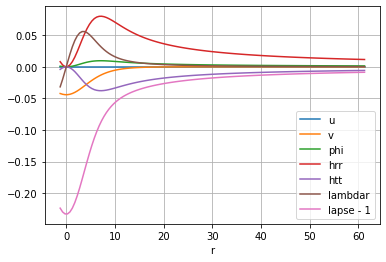

In [2]:
# Input parameters for grid and evolution here
N_r = 120 # num points on physical grid
R = 60.0 # Maximum outer radius

r, initial_vars_values = get_initial_vars_values(R, N_r)

#unpackage the vector for readability
initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, initial_K, initial_arr, initial_att, initial_app, initial_lambdar, initial_shiftr, initial_br, initial_lapse = unpack_vars_vector(initial_vars_values, N_r)

oneoverdxsquared = (R/N_r)**-2.0
diss = get_dissipation(initial_lambdar, oneoverdxsquared, 1.0)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, label='u')
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, diss, 'o', label='diss')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse-1, label='lapse - 1')
plt.legend(loc='best')
plt.grid()
#plt.xlim(-0.5,10)
#plt.ylim(-0.05,0.05)

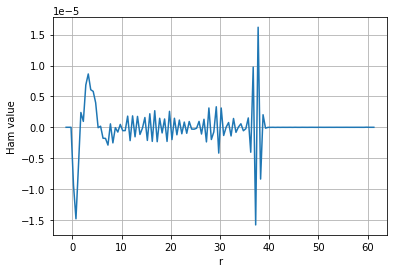

In [3]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
r, Ham = get_diagnostics(initial_vars_values, np.array([0]), R, N_r)

# plot the profile for Ham
plt.plot(r, Ham[0])

plt.xlabel('r')
plt.xlim(-4.0,R+4.0)
#plt.ylim(-0.01,0.01)
plt.ylabel('Ham value')
plt.grid()

In [5]:
# for control of time integrator and spatial grid
T = 25.0 # Maximum evolution time
N_t = 51 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/N_t
t = np.linspace(0, T-dt, N_t)
eta = 2.0 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_vars_values, args=(R, N_r, eta, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        max_step=(0.1*R/N_r), #for stability and for KO coeff of 10
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

100%|████████████████████████████████████████| 1000/1000 [09:41<00:00,  1.72‰/s]


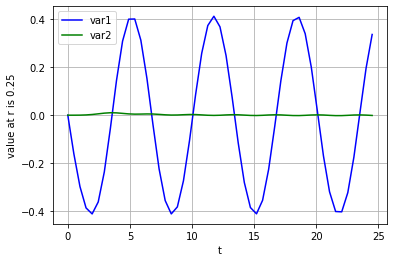

In [19]:
# Plot a single point versus time
N = N_r + num_ghosts * 2
var1 = idx_u
var2 = idx_phi

idx = num_ghosts
r_i = np.round(r[idx],2)
u_of_t = solution[0:N_t, var1 * N + idx]
plt.plot(t, 10*u_of_t, 'b-', label='var1')
v_of_t = solution[0:N_t, var2 * N + idx]
plt.plot(t, v_of_t, 'g-', label='var2')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
#plt.ylim(-0.0023, 0.0023)
plt.grid()

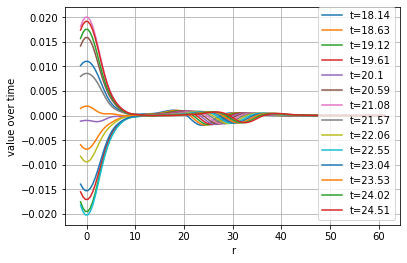

In [20]:
# plot the profile for some variable at a selection of times
var = idx_K

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 1 == 0) and (t_i > 18.0) :
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * N: (var + 1) * N]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
#plt.xlim(-1,5.0)
#plt.ylim(-0.001, 0.001)
plt.ylabel('value over time')
plt.grid()

In [16]:
# calculate the diagnostics, just the Hamiltonian constraint for now
r, Ham = get_diagnostics(solution, t, R, N_r)

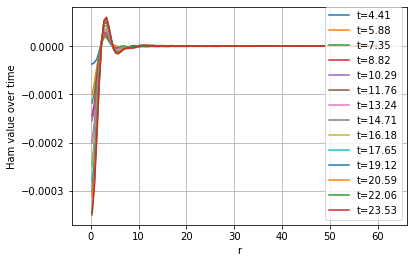

In [18]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 3 == 0) and (t_i > 4.0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        Ham_t = Ham_t[num_ghosts:(N-num_ghosts)]
        r_diagnostics = r[num_ghosts:(N-num_ghosts)]
        plt.plot(r_diagnostics, Ham_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-4.0,1.1*R)
plt.ylabel('Ham value over time')
plt.grid()